#Predicting Price with Location

In [ ]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

#Prepare Data

##Import

In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    df[["lat", "lon"]]=df["lat-lon"].astype(str).str.split(",",expand=True).astype(float)
    df.drop(columns=["lat-lon"],inplace=True)

    return df

In [ ]:
frame1 = wrangle("data/buenos-aires-real-estate-1.csv")
print(frame1.info())
frame1.head()

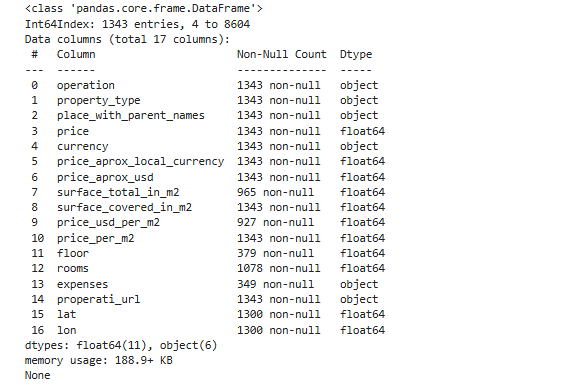

In [ ]:
frame2 = wrangle("data/buenos-aires-real-estate-2.csv")

In [ ]:
df = pd.concat([frame1,frame2])
print(df.info())
df.head()

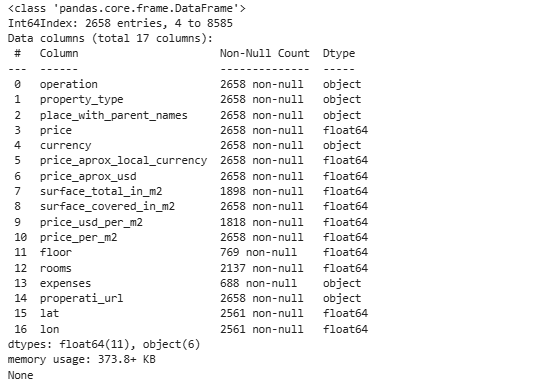

#Explore

In [ ]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat= "lat",
    lon= "lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color= df["price_aprox_usd"],
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

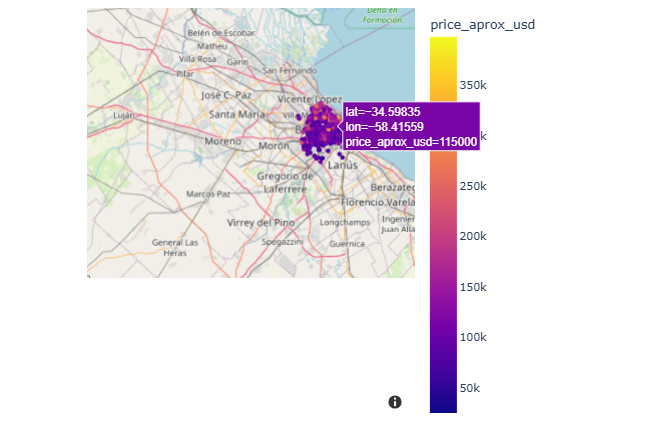

In [ ]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x= "lon",
    y= "lat",
    z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

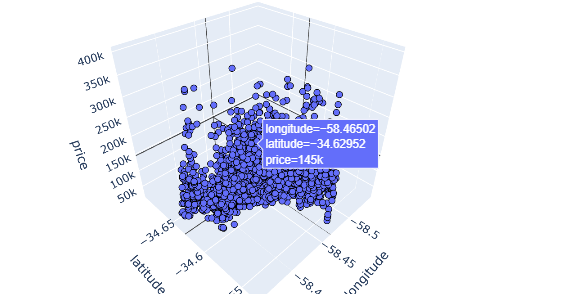

#Split

In [ ]:
features = ["lon", "lat"]
X_train = df[features]
target = "price_aprox_usd"
y_train = df[target]

#Build Model

##Baseline

In [ ]:
y_mean =y_train.mean()
mae_baseline = mean_absolute_error(y_train,[y_mean]*len(y_train))
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

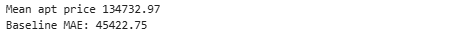

#Iterate

In [ ]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)
model.fit(X_train,y_train)

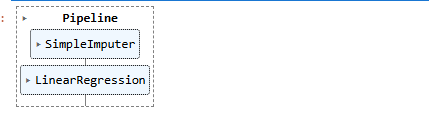

#Evaluate

In [ ]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)

#Communicate Results

In [ ]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print(
    f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)"
)

image.png

In [ ]:
fig = px.scatter_3d(
    df,
    x= "lon",
    y= "lat",
    z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

fig.show()

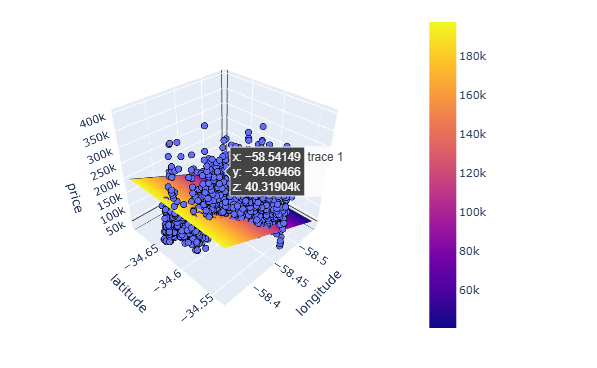